In [1]:
import numpy as np
import pandas as pd

from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM
from sklearn import preprocessing
from sklearn.metrics import (precision_score, recall_score,
                             f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
np.random.seed(0)
from tensorflow.keras.optimizers import RMSprop
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger


### word2vec

In [2]:
from __future__ import print_function
from collections import OrderedDict

import time
import _pickle as cPickle

import urllib
import matplotlib.pyplot as plt

import os
import sys
import codecs
import re
import numpy as np

parameters = OrderedDict()
parameters['word_dim'] = 300

In [3]:
datanew = pd.read_csv('../input/crowdflowerdata/text_emotion.csv', sep=',', engine='python', names=['tweet_id', 'sentiment', 'author', 'content'])
datanew.head()

,tweet_id,sentiment,author,content
0,tweet_id,sentiment,author,content
1,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
2,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
3,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
4,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!


In [4]:
## encode sentiment column to onehot
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(datanew['sentiment'].to_numpy().reshape(-1, 1))
onehot_sentiment = enc.transform(datanew['sentiment'].to_numpy().reshape(-1, 1)).toarray()
# onehot_sentiment = onehot_sentiment.reshape((40000, 1, 13))
datanew.insert(1, "onehot_sentiment", list(onehot_sentiment))
datanew

,tweet_id,onehot_sentiment,sentiment,author,content
0,tweet_id,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",sentiment,author,content
1,1956967341,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
2,1956967666,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
3,1956967696,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",sadness,coolfunky,Funeral ceremony...gloomy friday...
4,1956967789,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",enthusiasm,czareaquino,wants to hang out with friends SOON!
...,...,...,...,...,...
39996,1753918954,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",neutral,showMe_Heaven,@JohnLloydTaylor
39997,1753919001,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",love,drapeaux,Happy Mothers Day All my love
39998,1753919005,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",love,JenniRox,Happy Mother's Day to all the mommies out ther...
39999,1753919043,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",happiness,ipdaman1,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


### encode word

In [5]:
def create_dico(item_list):
    """
    Create a dictionary of items from a list of list of items.
    (item:count) pairs
    """
    assert type(item_list) is list
    dico = {}
    for items in item_list:
        for item in items:
            if item not in dico:
                dico[item] = 1
            else:
                dico[item] += 1
    return dico

def create_mapping(dico):
    """
    Create a mapping (item to ID / ID to item) from a dictionary.
    Items are ordered by decreasing frequency.
    """
    sorted_items = sorted(dico.items(), key=lambda x: (-x[1], x[0]))
    id_to_item = {i: v[0] for i, v in enumerate(sorted_items)}
    item_to_id = {v: k for k, v in id_to_item.items()}
    return item_to_id, id_to_item

def word_mapping(sentences, lower):
    """
    Create a dictionary and a mapping of words, sorted by frequency.
    
    return:
    dico: dictionary of (word:frequency) pairs
    word_to_id: dictionary of (word, id)
    id_to_word: dictionary of (id, word)
    """
    words = [[x.lower() if lower else x[0] for x in s] for s in sentences]
    dico = create_dico(words)
    dico['<UNK>'] = 10000000 #UNK tag for unknown words
    word_to_id, id_to_word = create_mapping(dico)
    print("Found %i unique words (%i in total)" % (
        len(dico), sum(len(x) for x in words)
    ))
    return dico, word_to_id, id_to_word

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
## tokenising sentences
raw_content = datanew['content'].to_numpy()

processed_docs = []
for doc in raw_content:
    tokens = word_tokenize(doc)
#        filtered = [word for word in tokens if word not in stop_words]
#        stemmed = [stemmer.stem(word) for word in filtered]
    processed_docs.append(tokens)

In [8]:
dico_words,word_to_id,id_to_word = word_mapping(processed_docs, True)

Found 52746 unique words (654847 in total)


In [9]:
def lower_case(x,lower=False):
    if lower:
        return x.lower()  
    else:
        return x

In [10]:
def prepare_dataset(sentences, word_to_id, lower=False):
    """
    Prepare the dataset. Return a list of lists of dictionaries containing:
        - word indexes
        - word char indexes
        - tag indexes
    """
    data = []
    for s in sentences:
        str_words = [w for w in s]
        words = [word_to_id[lower_case(w,lower) if lower_case(w,lower) in word_to_id else '<UNK>']
                 for w in str_words]
        data.append({
            'str_words': str_words, #list of all words in the sentence
            'words': words, #list of word index for all words in the sentence
        })
    return data

data = prepare_dataset(
    processed_docs, word_to_id, True
)

print("{} sentences".format(len(data)))

40001 sentences


In [11]:
all_word_embeds = {}
for i, line in enumerate(codecs.open('../input/crowdflowerdata/glove.6B.300d.txt', 'r', 'utf-8')):
    s = line.strip().split()
    if len(s) == parameters['word_dim'] + 1:
        all_word_embeds[s[0]] = np.array([float(i) for i in s[1:]])

#Intializing Word Embedding Matrix
word_embeds = np.random.uniform(-np.sqrt(0.06), np.sqrt(0.06), (len(word_to_id), parameters['word_dim']))

for w in word_to_id:
    if w in all_word_embeds:
        word_embeds[word_to_id[w]] = all_word_embeds[w]
    elif w.lower() in all_word_embeds:
        word_embeds[word_to_id[w]] = all_word_embeds[w.lower()]

print('Loaded %i pretrained embeddings.' % len(all_word_embeds))

Loaded 400000 pretrained embeddings.


In [12]:
word_indices = [i['words'] for i in data]
padded_indices = []
for sent in word_indices:
    padding_size = 110 - len(sent)
    padded = sent + [0 for i in range(padding_size)]
    padded_indices.append(padded)

In [13]:
datanew.insert(1, "padded_indices", list(padded_indices))
datanew

,tweet_id,padded_indices,onehot_sentiment,sentiment,author,content
0,tweet_id,"[2301, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",sentiment,author,content
1,1956967341,"[4, 48864, 1, 67, 1, 36, 3311, 5, 138, 4779, 8...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
2,1956967666,"[12504, 316, 162, 33, 8, 439, 3667, 13, 2272, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
3,1956967696,"[2713, 4125, 13, 1714, 246, 13, 0, 0, 0, 0, 0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",sadness,coolfunky,Funeral ceremony...gloomy friday...
4,1956967789,"[441, 5, 700, 43, 33, 227, 186, 2, 0, 0, 0, 0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",enthusiasm,czareaquino,wants to hang out with friends SOON!
...,...,...,...,...,...,...
39996,1753918954,"[4, 6649, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",neutral,showMe_Heaven,@JohnLloydTaylor
39997,1753919001,"[61, 157, 32, 40, 9, 56, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",love,drapeaux,Happy Mothers Day All my love
39998,1753919005,"[61, 141, 18, 32, 5, 40, 6, 1576, 43, 71, 7, 3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",love,JenniRox,Happy Mother's Day to all the mommies out ther...
39999,1753919043,"[4, 8652, 2806, 388, 2, 2, 2, 262, 24, 2, 2, 6...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",happiness,ipdaman1,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [14]:
from sklearn.model_selection import train_test_split
X = datanew['padded_indices'].to_numpy()
y = datanew['onehot_sentiment'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("X train: ", len(X_train), X_train.shape)
print("y train: ", len(y_train), y_train.shape)
print("y test: ", len(y_test), y_test.shape)

X train:  28000 (28000,)
y train:  28000 (28000,)
y test:  12001 (12001,)


In [15]:
X_train = np.array([np.array(x) for x in X_train])
y_train = np.array([np.array(x) for x in y_train])
X_test = np.array([np.array(x) for x in X_test])
y_test = np.array([np.array(x) for x in y_test])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(28000, 110)
(28000, 14)
(12001, 110)
(12001, 14)


### RNN with lstm model

In [16]:
# so that dont have to rerun
import tensorflow as tf
tf.compat.v1.reset_default_graph()

In [17]:
import tensorflow as tf

class RNNModel:

    def __init__(self,
        embedding,
        em_drop_rate = 0.5,
        rnn_units   = 300,
        rnn_drop_rate = 0.2):
        '''Constructor.
        # Parameters:
        embedding: Numpy array representing the embedding.
        em_drop_rate: Drop rate after the embedding layer.
        lstm_units: Size of the internal states of the LSTM cells.
        lstm_drop_rate: Drop rate after the lstm layer.
        '''
        self._embedding      = embedding
        self._em_drop_rate   = em_drop_rate
        self._rnn_units     = rnn_units
        self._rnn_drop_rate = rnn_drop_rate

    def __call__(self, input):
        self._embedding_tf = self._create_embedding_layer(
            self._em_drop_rate, self._embedding, input)

        self._rnn_tf = self._create_rnn_layer(
            self._rnn_units,
            self._rnn_drop_rate,
            self._embedding_tf)

        self._flatten_tf = self._create_flatten_layer(self._rnn_tf)

        return self._flatten_tf

    def summary(self):
        print("embedding: " + str(self._embedding_tf.shape))
        print("rnn: " + str(self._rnn_tf.shape))
        print("flatten: " + str(self._flatten_tf.shape))

    # this function converts each word from input_x into dense vector of dimension 300 (dimension depending on word2vec)
    # embedding  = word_vector
    def _create_embedding_layer(self, em_drop_rate, embedding, input_x):
        embedding = tf.Variable(initial_value=embedding)

        embedded_chars = tf.nn.embedding_lookup(  # lookup word_vector(embedding) by index (input_x)
            embedding, tf.cast(input_x, 'int32'))

        return tf.nn.dropout(embedded_chars, rate=em_drop_rate)

    def _create_rnn_layer(self, rnn_units, rnn_drop_rate, embedding):
        rnn_cell = tf.compat.v1.nn.rnn_cell.BasicRNNCell(rnn_units)
        sequence = tf.unstack(embedding, axis=1) #embedded input words
        
        # hs, _, _ are outputs, output_state_fw, output_state_bw respectively
        hs, _, _ = tf.compat.v1.nn.static_bidirectional_rnn(rnn_cell, rnn_cell, #forward and backward direction
            sequence, #input
            dtype=tf.float32)
        
        hs = tf.stack(
            values=hs,
            axis=1)
        ss = tf.math.reduce_sum(
            tf.reshape(hs, shape=[-1, hs.shape[1], 2, rnn_units]),
            axis=2
        )

        return tf.nn.dropout(ss, rate=rnn_drop_rate)

    def _create_flatten_layer(self, tensor):
        return tf.reshape(tensor, [-1, tensor.shape[1] * tensor.shape[2]])


if __name__ == '__main__':
    embedding_size  = 300
    num_words       = 1000
    sentence_length = 10

    embedding = [
        [float(i) for i in range(embedding_size)] for _ in range(num_words)
    ]
    data = [
        [i     for i in range(sentence_length)],
        [i + 1 for i in range(sentence_length)]
    ]

    model = RNNModel(embedding)
    model(data)
    model.summary()

2021-11-13 08:24:29.242945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 08:24:29.348415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 08:24:29.349146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 08:24:29.350315: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

embedding: (2, 10, 300)
rnn: (2, 10, 300)
flatten: (2, 3000)


In [18]:
import tensorflow as tf
from numba import jit, cuda

class Classifier:

    def __init__(self, model, input_length, output_length):
        '''Constructor.
        # Parameters:
        input_length: sentence length (max number of words in sentence)
        output_length: number of classes of sentiment
        '''
        self.model = model
        self.input_length = input_length
        self.output_length = output_length

    def compile(self, batch_size=32):
        tf.compat.v1.disable_eager_execution()
        self._ds_x = tf.compat.v1.placeholder(tf.float32, [None, self.input_length])
        self._ds_y = tf.compat.v1.placeholder(tf.float32, [None, self.output_length])

        ds = tf.compat.v1.data.Dataset.from_tensor_slices((self._ds_x, self._ds_y))
        ds = ds.batch(batch_size)

        self._ds_it = ds.make_initializable_iterator()
        self._input, self._labels = self._ds_it.get_next()

        self._features = self.model(self._input)
        self._output = _create_dense_layer(self._features, self.output_length)

        self._create_acc_computations()
        self._create_backpropagation()

        self._session = tf.compat.v1.Session()
        self._session.run(tf.compat.v1.global_variables_initializer())
        self._session.run(tf.compat.v1.local_variables_initializer())

    def _create_acc_computations(self):
        self._predictions = tf.argmax(self._output, 1)
        labels = tf.argmax(self._labels, 1)
        self._accuracy = tf.reduce_mean(
            tf.cast(tf.equal(self._predictions, labels), 'float32'))

    def _create_backpropagation(self):
        losses = tf.compat.v1.nn.softmax_cross_entropy_with_logits_v2(
            logits=self._output,
            labels=self._labels)
        self._loss = tf.reduce_mean(losses)

        optimizer = tf.compat.v1.train.AdamOptimizer(0.001)
        global_step = tf.Variable(0, name="global_step", trainable=False)
        grads_and_vars = optimizer.compute_gradients(self._loss)

        self._train_op = optimizer.apply_gradients(
            grads_and_vars, global_step=global_step)

    def summary(self):
        print('input:', self._input.shape)
        self.model.summary()
        print('output:', self._output.shape)

#     @jit(target ="cuda")  
    def train(self, X_train, y_train, X_eval, y_eval, epochs=20):
        import time
        start_train = time.time()
        losslist = []
        acclist = []
        val_losslist = []
        val_acclist =[]

        for e in range(epochs):
            start_time = time.time()
            loss, acc = self._train(X_train, y_train)
            losslist.append(loss)
            acclist.append(acc)
            duration = time.time() - start_time

            val_loss, val_acc = self._eval(X_eval, y_eval)
            val_losslist.append(val_loss)
            val_acclist.append(val_acc)

            output = 'Epoch: {}, loss = {:.4f}, acc = {:.4f}, val_loss = {:.4f}, val_acc = {:.4f}, Time = {:.2f}s'
            print(output.format(e + 1, loss, acc, val_loss, val_acc, duration))
        
        total_duration = time.time() - start_train
        return losslist, acclist, val_losslist, val_acclist, total_duration

#     @jit(target ="cuda")  
    def _train(self, X_train, y_train):
        import numpy as np

        self._session.run(
            fetches=self._ds_it.initializer,
            feed_dict={
                self._ds_x: X_train,
                self._ds_y: y_train
            })
        loss, acc, = [], []
        while True:
            try:
                _, vloss, vacc = self._session.run(
                    fetches=[self._train_op, self._loss, self._accuracy])

                loss.append(vloss)
                acc.append(vacc)
            except tf.errors.OutOfRangeError:
                break
        # endwhile

        loss, acc = np.mean(loss), np.mean(acc)
        return loss, acc

    def _eval(self, X_val, y_val):
        self._session.run(
            fetches=self._ds_it.initializer,
            feed_dict={
                self._ds_x: X_val,
                self._ds_y: y_val
            })

        loss, acc, = 0, 0
        while True:
            try:
                l, vloss, vacc = self._session.run(
                    fetches=[self._labels, self._loss, self._accuracy])

                loss += vloss * len(l)
                acc += vacc * len(l)
            except tf.errors.OutOfRangeError:
                break

        return loss / len(X_val), acc / len(X_val)

    def predict(self, X):
        import numpy as np

        self._session.run(self._ds_it.initializer,
                         feed_dict={
                             self._ds_x: X,
                             self._ds_y: np.empty((len(X), self.output_length))
                         }
                         )

        pred = list()
        while True:
            try:
                ppred = self._session.run(tf.nn.softmax(self._output))

                pred.extend(map(lambda l: l.tolist(), ppred))
            except tf.errors.OutOfRangeError:
                break

        return pred

def _create_dense_layer(x, output_length):
    '''Creates a dense layer
    '''
    input_size = x.shape[1] #.value
    W = tf.Variable(
        initial_value=tf.random.truncated_normal(
            shape=[input_size, output_length],
            stddev=0.1))
    b = tf.Variable(
        initial_value=tf.random.truncated_normal(
            shape=[output_length]))

    dense = tf.compat.v1.nn.xw_plus_b(x, W, b)

    return dense


if __name__ == '__main__':
    pass

In [19]:
import pickle
import numpy as np
import sys
# from fen.classifier import Classifier
# from fen.pzhou_tf import ZhouBLSTMCNNModel

if __name__ == '__main__':

#     (X_train, y_train), (X_eval, y_eval) = (X_train, y_train), (X_test, y_test)

    word_vector = word_embeds
    word_vector = word_vector.astype('float32')
    
    sentence_length = X_train[0].shape[0] # sentence length = 37 -- if less than 37, remaining is 0
    num_classes = y_train[0].shape[0] # 6 sentiment classes

    # tf.debugging.set_log_device_placement(True)
    # with tf.device('/device:GPU:0'):
    model = RNNModel(embedding=word_vector) #pass in word_vector as lookup table

    classifier = Classifier(
        model=model,
        input_length=sentence_length,
        output_length=num_classes)

    classifier.compile(batch_size=32)
    classifier.summary()
    loss, acc, val_loss, val_acc, duration = classifier.train(
        X_train=X_train,
        y_train=y_train,
        X_eval=X_test,
        y_eval=y_test,
        epochs=20
    )

    print("total time taken: ", duration)
    print("Predictions:", classifier.predict(X_train[0:2]))
    print("Real:", y_train[0:2])

/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
2021-11-13 08:24:37.880048: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 08:24:37.881174: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 08:24:37.881877: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 08:24:37.882658: I tensorflow/stream_executor/cuda/cuda_gpu_e

input: (None, 110)
embedding: (None, 110, 300)
rnn: (None, 110, 300)
flatten: (None, 33000)
output: (None, 14)
Epoch: 1, loss = 7.3194, acc = 0.1821, val_loss = 5.0185, val_acc = 0.2088, Time = 27.64s
Epoch: 2, loss = 3.9586, acc = 0.2541, val_loss = 4.2738, val_acc = 0.1957, Time = 25.73s
Epoch: 3, loss = 3.0618, acc = 0.3086, val_loss = 3.9715, val_acc = 0.2149, Time = 27.64s
Epoch: 4, loss = 2.5424, acc = 0.3763, val_loss = 3.9146, val_acc = 0.2262, Time = 27.14s
Epoch: 5, loss = 2.1139, acc = 0.4585, val_loss = 4.0919, val_acc = 0.2168, Time = 27.51s
Epoch: 6, loss = 1.7926, acc = 0.5303, val_loss = 4.4560, val_acc = 0.2054, Time = 27.60s
Epoch: 7, loss = 1.5486, acc = 0.5938, val_loss = 4.6588, val_acc = 0.2176, Time = 27.44s
Epoch: 8, loss = 1.3740, acc = 0.6438, val_loss = 5.1045, val_acc = 0.2141, Time = 25.79s
Epoch: 9, loss = 1.2460, acc = 0.6819, val_loss = 5.3359, val_acc = 0.2224, Time = 27.58s
Epoch: 10, loss = 1.1213, acc = 0.7184, val_loss = 5.7302, val_acc = 0.2168, Ti

In [20]:
### Plot graphs

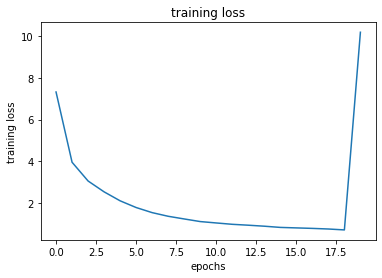

In [21]:
epochslist = [i for i in range(0,20)]
plt.plot(epochslist, loss)
plt.title('training loss')
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.show()

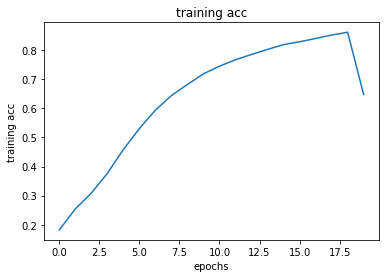

In [22]:
plt.plot(epochslist, acc)
plt.title('training acc')
plt.xlabel('epochs')
plt.ylabel('training acc')
plt.show()

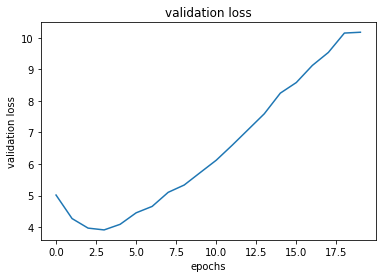

In [23]:
plt.plot(epochslist, val_loss)
plt.title('validation loss')
plt.xlabel('epochs')
plt.ylabel('validation loss')
plt.show()

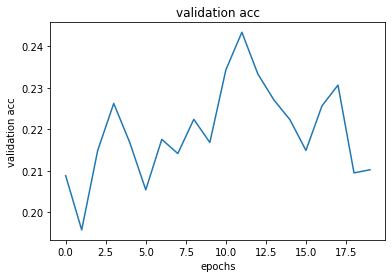

In [24]:
plt.plot(epochslist, val_acc)
plt.title('validation acc')
plt.xlabel('epochs')
plt.ylabel('validation acc')
plt.show()

### testing

In [25]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [26]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2021-11-13 08:39:25.886657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 08:39:25.887240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 08:39:25.887579: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 08:39:25.888054: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 08:39:25.888430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S